In [12]:
!pip install --quiet pandas pandas_datareader numpy matplotlib scikit-learn tensorflow

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0467 - mean_absolute_error: 0.1560 - val_loss: 0.0165 - val_mean_absolute_error: 0.1234
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0013 - mean_absolute_error: 0.0285 - val_loss: 0.0020 - val_mean_absolute_error: 0.0366
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.2705e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0011 - val_mean_absolute_error: 0.0260
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.7456e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0013 - val_mean_absolute_error: 0.0281
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 5.9587e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.3658e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0020 - val_mean_absolute_error: 0.0380
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.9589e-04 - mean_absolute_error: 0.0190 -

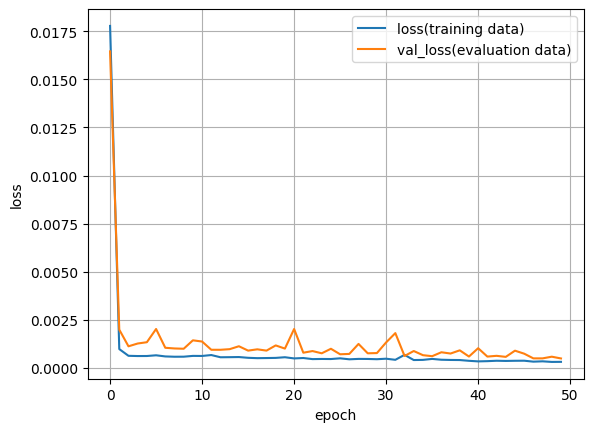

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


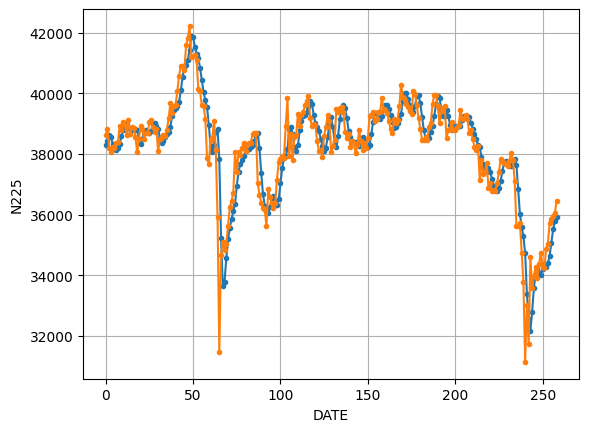

0.7930916746406566

In [41]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

nikkei = web.DataReader("NIKKEI225", "fred", "2020/5/1", "2025/5/1")
nikkei = nikkei.interpolate()

data = nikkei.values

scaler = MinMaxScaler(feature_range=(0,1))
NikkeiData_norm = scaler.fit_transform(data)

maxlen = 10
x_data = []
y_data_price = []

for i in range(len(NikkeiData_norm) - maxlen):
    x_data.append(NikkeiData_norm[i:i + maxlen])
    y_data_price.append(NikkeiData_norm[i + maxlen])

x_data = np.asarray(x_data)
y_data_price = np.asarray(y_data_price)

x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

train_size = int(x_data.shape[0] * 0.8)
x_train = x_data[:train_size]
y_train_price = y_data_price[:train_size]
x_test = x_data[train_size:]
y_test_price = y_data_price[train_size:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

out_neurons = 1
units = 300

model = Sequential()
model.add(LSTM(units, input_shape=(maxlen, 1), return_sequences=False))
model.add(Dense(out_neurons))

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[metrics.mae])

early_stopping = EarlyStopping(monitor='val_mean_absolute_error', mode='auto', patience=7)

hist = model.fit(
    x_train, y_train_price,
    batch_size=30,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stopping]
)

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = len(loss)

plt.plot(range(epochs), loss, label='loss(training data)')
plt.plot(range(epochs), val_loss, label='val_loss(evaluation data)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

predicted = model.predict(x_test)

predicted_N    = scaler.inverse_transform(predicted)                   # (n,1) → (n,1)
y_test_price_N = scaler.inverse_transform(y_test_price.reshape(-1,1))  # reshape to (n,1)

plt.plot(range(len(predicted)), predicted_N, marker='.', label='predicted')
plt.plot(range(len(y_test_price)), y_test_price_N, marker='.', label='y_test_price')
plt.grid()
plt.xlabel('DATE')
plt.ylabel('N225')
plt.show()

from sklearn.metrics import r2_score
r2_score(predicted_N,y_test_price_N)

In [42]:
model.save('/content/nikkei_lstm.h5')
print("Model saved.")

Model saved.


In [43]:
import joblib
joblib.dump(scaler, '/content/nikkei_scaler.pkl')
print("Scaler saved.")

Scaler saved.


In [44]:
!ls /content | grep nikkei

nikkei_lstm.h5
nikkei_scaler.pkl


In [45]:
from google.colab import files

files.download('/content/nikkei_lstm.h5')
files.download('/content/nikkei_scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>